# Setup Deephys

## 1. Install dependencies

In [1]:
#@title 1. Install dependencies

!pip install torch torchvision # We will use Torch as the deep net platform
!pip install deephys==0.14.0 # To export the neural activity to deephys

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 2. Define neural net model

In [2]:
#@title 2. Define neural net model

#Import Libraries
from __future__ import print_function
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import os, pickle
from transformers import CvtForImageClassification #Architectures from huggingface

## 3. Load the model. Define hooks to extract the neural activity from the network

In [3]:
#@title 3. Load the model. Define hooks to extract the neural activity from the network
args={}
args['batch_size'] = 256
args['cuda'] = True # Enabling cuda is required

#Load pre-trained model (from Huggingface)
model = CvtForImageClassification.from_pretrained("microsoft/cvt-13") 
if args['cuda']:
    model.cuda()
model.eval() # testing model

# Hooks to extract the neural activity from the model
model_activity = {}
def get_activation(name):
  def hook(model, input, output):
    model_activity[name] = output.detach()
  return hook

# We will only pull from the linear1 layer
h = model.cvt.encoder.stages[2].layers[9].register_forward_hook(get_activation('linear1'))

## 4. Define function to extract data from the model to be exported to Deephys 

In [4]:
#@title 4. Define function to extract data from the model to be exported to Deephys 

def extract_activity(testloader, model):
    
  # All we need for Deephys
  dp_images = []
  dp_gt = []
  dp_activity = {
      "output": [], 
      "linear1": []
  }

  # Standard normalization for ImageNet versions
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

  # Resize the data only for visualization in deephys
  resize = transforms.Resize((64,64))

  # Loop across all dataset 
  for data, target in iter(testloader):

      resized_data = resize(data)

      dp_images.append(resized_data)
      dp_gt.append(target)

      if args['cuda']:
        data, target = data.cuda(), target.cuda()

      data = normalize(data) # Required to capture activations with normalized data

      with torch.no_grad():
        tmp_activity = model(data).logits.detach().cpu()
        dp_activity['output'].append(tmp_activity)
        tmp_activity = torch.relu(torch.squeeze(model_activity['linear1']).detach()).cpu()
        dp_activity['linear1'].append(tmp_activity.mean(axis=1))

  # Convert torch tensors to numpy
  for layer in dp_activity:
        dp_activity[layer] = torch.cat(dp_activity[layer]).numpy()

  dp_images = torch.cat(dp_images).numpy()
  dp_gt = torch.cat(dp_gt).numpy()

  return dp_images, dp_gt, dp_activity

## 5. Deephys model

In [5]:
#@title 5. Deephys model

import deephys as dp

#List containing ImageNet category IDs and categories
classes = []
with open('./imagenet1000_clsidx_to_labels.txt') as f:
    lines = f.readlines()
    
classes = [line.split(":")[1].strip() for line in lines]

dp_model = dp.model(
    name = "cvt13_imagenet",
    layers = {
        "linear1": model.classifier.in_features,
        "output": len(classes)
    },
    classification_layer="output"
)

dp_model.save()

Saving data to cvt13_imagenet.model...
done saving data to cvt13_imagenet.model


## 6. Export data from ImageNet to Deephys

In [7]:
#@title 6. Export data from ImageNet to Deephys

#Load ImageNet
valdir = './path-to-ImageNet-val/' #Provide path to ImageNet validation dataset

testloader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
                transforms.Resize(
                    256,
                    2
                ),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])),
            batch_size=args['batch_size'],
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            drop_last=False)

IN_images, IN_gt, IN_activity = extract_activity(testloader, model)

# To Deephys
dataset_activity = dp.dataset_activity(
    name = "ImageNetV1_cvt13",
    category_names = classes,
    images = IN_images,
    groundtruth = IN_gt,
    neural_activity = IN_activity,
    model=dp_model,
    )
dataset_activity.save()

Preparing data...


100%|██████████| 50000/50000 [00:53<00:00, 930.29it/s] 


Saving data to ImageNetV1_cvt13.test...
done saving data to ImageNetV1_cvt13.test


## 7. Export data from ImageNetV2 to Deephys

In [8]:
#@title 7. Export data from ImageNetV2 to Deephys

#Load ImageNetV2
valdir = './path-to-ImageNetV2-val/' #Provide path to ImageNetV2 validation dataset

testloader_v2 = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
                transforms.Resize(
                    256,
                    2
                ),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])),
            batch_size=args['batch_size'],
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            drop_last=False)

IN_v2_images, IN_v2_gt, IN_v2_activity = extract_activity(testloader_v2, model)

# To Deephys
dataset_activity = dp.dataset_activity(
    name = "ImageNetV2_cvt13",
    category_names = classes,
    images = IN_v2_images,
    groundtruth = IN_v2_gt,
    neural_activity = IN_v2_activity,
    model=dp_model,
    )
dataset_activity.save()

Preparing data...


100%|██████████| 10000/10000 [00:10<00:00, 943.89it/s]


Saving data to ImageNetV2_cvt13.test...
done saving data to ImageNetV2_cvt13.test


## 8. Export data from ImageNet Sketch to Deephys

In [9]:
#@title 8. Export data from ImageNet Sketch to Deephys

#Load ImageNet Sketch
valdir = './path-to-ImageNet-Sketch-val/' #Provide path to ImageNet Sketch validation dataset

testloader_sketch = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
                transforms.Resize(
                    256,
                    2
                ),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])),
            batch_size=args['batch_size'],
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            drop_last=False)

IN_sketch_images, IN_sketch_gt, IN_sketch_activity = extract_activity(testloader_sketch, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "ImageNet_sketch_cvt13",
    category_names = classes,
    images = IN_sketch_images,
    groundtruth = IN_sketch_gt,
    neural_activity = IN_sketch_activity,
    model=dp_model,
    )
dataset_activity.save()

Preparing data...


100%|██████████| 50889/50889 [00:57<00:00, 888.51it/s]


Saving data to ImageNet_sketch_cvt13.test...
done saving data to ImageNet_sketch_cvt13.test


## 9. Export data from Stylized ImageNet to Deephys

In [10]:
#@title 9. Export data from Stylized ImageNet to Deephys

#Load Stylized ImageNet
valdir = './path-to-ImageNet-Style-val/' #Provide path to Stylized ImageNet validation dataset

testloader_style = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
                transforms.Resize(
                    256,
                    2
                ),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])),
            batch_size=args['batch_size'],
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            drop_last=False)

IN_style_images, IN_style_gt, IN_style_activity = extract_activity(testloader_style, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "ImageNet_style_cvt13",
    category_names = classes,
    images = IN_style_images,
    groundtruth = IN_style_gt,
    neural_activity = IN_style_activity,
    model=dp_model,
    )
dataset_activity.save()

Preparing data...


100%|██████████| 50000/50000 [00:55<00:00, 898.82it/s]


Saving data to ImageNet_style_cvt13.test...
done saving data to ImageNet_style_cvt13.test


# Novelty and Spurious Scores

In [11]:
#@title Normalize and get average firing rates per category

num_neurons = model.classifier.in_features
num_classes = len(classes)

norm = np.max(IN_activity["linear1"], axis=0)
IN_activity["linear1"] /= norm
IN_v2_activity["linear1"] /= norm
IN_sketch_activity["linear1"] /= norm
IN_style_activity["linear1"] /= norm


# average scores for every concept across all images
Y = np.array([np.mean(IN_activity["linear1"][np.where(IN_gt == c)[0], :], axis=0) 
          for c in range(num_classes)]) #ImageNet

Y_v2 = np.array([np.mean(IN_v2_activity["linear1"][np.where(IN_v2_gt == c)[0], :], axis=0) 
          for c in range(num_classes)]) #ImageNetV2

Y_sketch = np.array([np.mean(IN_sketch_activity["linear1"][np.where(IN_sketch_gt == c)[0], :], axis=0) 
          for c in range(num_classes)]) #ImageNet Sketch

Y_style = np.array([np.mean(IN_style_activity["linear1"][np.where(IN_style_gt == c)[0], :], axis=0) 
          for c in range(num_classes)]) #Stylized ImageNet

## Calculate Spurious and Novelty scores

In [12]:
#@title Calculate Spurious and Novelty scores

from scipy.stats.mstats import spearmanr
import pandas as pd

def Spurious_Score(avg_acts_1, avg_acts_2):
    #Spearman's rank correlation calculation
    spearman_corr = [1-abs(spearmanr(avg_acts_1[:,i], avg_acts_2[:,i])[0])
          for i in range(len(avg_acts_1[0]))]
    
    return spearman_corr

def Novelty_Score(avg_acts_1, avg_acts_2):
  max_acts = np.max(avg_acts_1, axis=0)
  max_acts_2 = np.max(avg_acts_2, axis=0)

  diff_acts = list(max_acts - max_acts_2)
  return diff_acts


# Calculate and store in dataframe
spurious_v2 = Spurious_Score(Y, Y_v2)
spurious_sketch = Spurious_Score(Y, Y_sketch)
spurious_style = Spurious_Score(Y, Y_style)

novelty_v2 = Novelty_Score(Y, Y_v2)
novelty_sketch = Novelty_Score(Y, Y_sketch)
novelty_style = Novelty_Score(Y, Y_style)

df = pd.DataFrame({
  'Spurious_v2': spurious_v2,
  'Spurious_sketch': spurious_sketch,
  'Spurious_style': spurious_style,
  'Novelty_v2': novelty_v2,
  'Novelty_sketch': novelty_sketch,
  'Novelty_style': novelty_style
})

## Plot scores

<ipython-input-13-cc30133ebc8e>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['Spurious_v2'], shade=True, color="r")
<ipython-input-13-cc30133ebc8e>:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['Spurious_sketch'], shade=True, color="b")
<ipython-input-13-cc30133ebc8e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['Spurious_style'], shade=True, color="g")


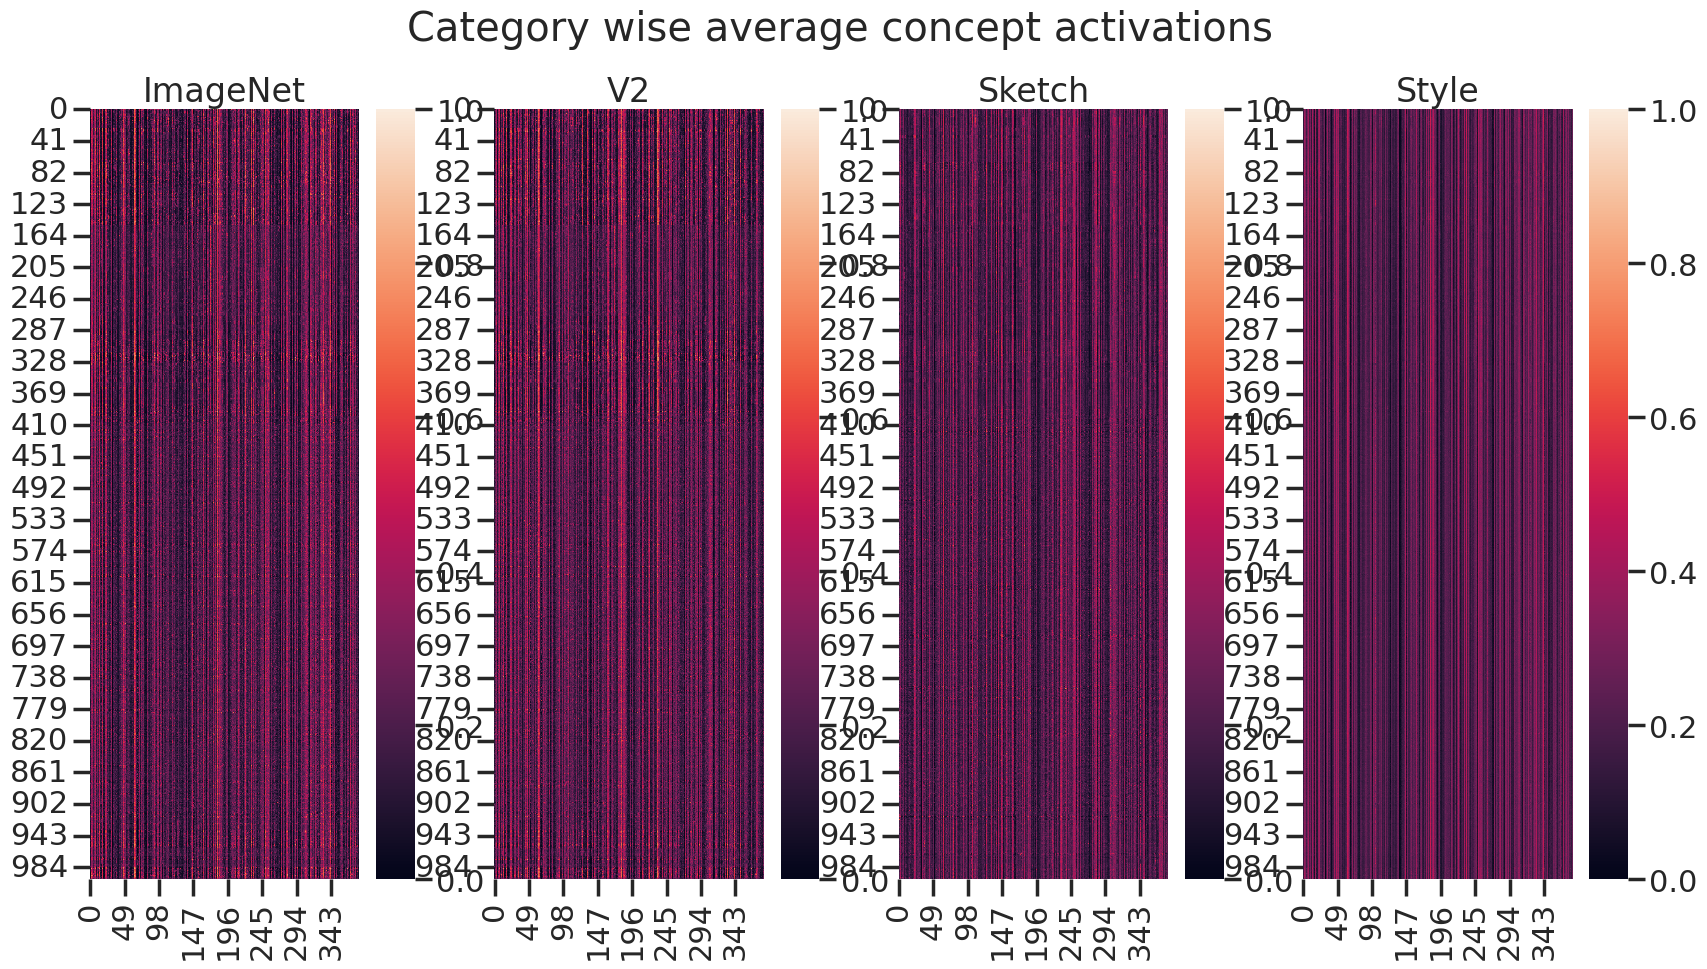

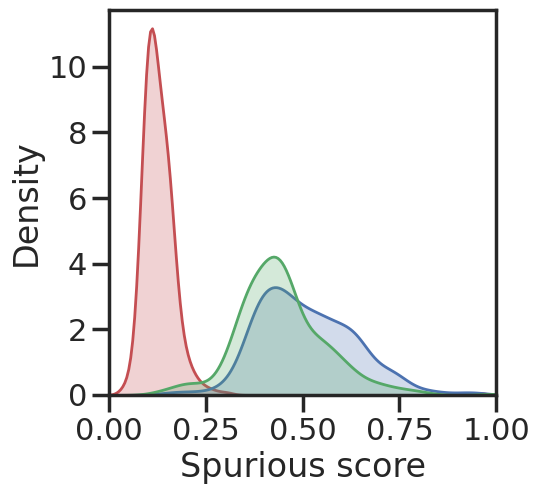

<ipython-input-13-cc30133ebc8e>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['Novelty_v2'], shade=True, color="r")
<ipython-input-13-cc30133ebc8e>:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['Novelty_sketch'], shade=True, color="b")
<ipython-input-13-cc30133ebc8e>:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['Novelty_style'], shade=True, color="g")


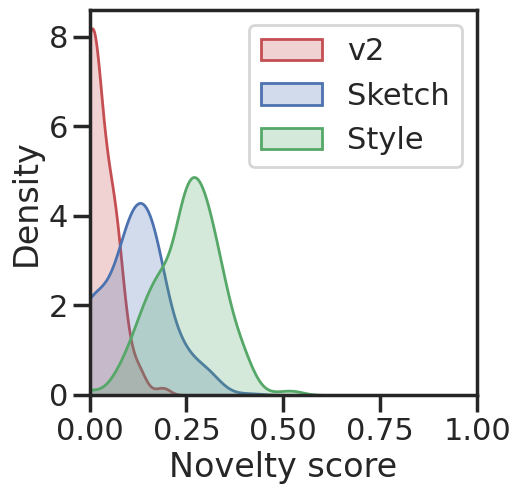

In [13]:
#@title Plot scores

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set_context("poster")


fig, axes = plt.subplots(1, 4, figsize = (20, 10))
fig.suptitle('Category wise average concept activations')
fig = sns.heatmap(Y, ax=axes[0], vmin=0, vmax=1)
fig = sns.heatmap(Y_v2, ax=axes[1], vmin=0, vmax=1)
fig = sns.heatmap(Y_sketch, ax=axes[2], vmin=0, vmax=1)
fig = sns.heatmap(Y_style, ax=axes[3], vmin=0, vmax=1)

axes[0].set_title('ImageNet')
axes[1].set_title('V2')
axes[2].set_title('Sketch')
axes[3].set_title('Style')


fig, axes = plt.subplots(1, 1, figsize = (5, 5))
fig = sns.kdeplot(df['Spurious_v2'], shade=True, color="r")
fig = sns.kdeplot(df['Spurious_sketch'], shade=True, color="b")
fig = sns.kdeplot(df['Spurious_style'], shade=True, color="g")
plt.xlim(0, 1)
axes.set_xlabel('Spurious score')

plt.show()
g = fig.figure
g.savefig("IN_spurious_cvt_new.pdf", bbox_inches='tight')

fig, axes = plt.subplots(1, 1, figsize = (5, 5))
fig = sns.kdeplot(df['Novelty_v2'], shade=True, color="r")
fig = sns.kdeplot(df['Novelty_sketch'], shade=True, color="b")
fig = sns.kdeplot(df['Novelty_style'], shade=True, color="g")
plt.xlim(0, 1)
plt.gca().legend(('v2','Sketch', 'Style'), loc ="upper right")
axes.set_xlabel('Novelty score')

plt.show()
g = fig.figure
g.savefig("IN_novelty_cvt_new.pdf", bbox_inches='tight')